# EXOTIC OPTION PRICING

**Problem Statement:** <br>
We need to price quotes for custom European basket options with knock-out features. The basket is created on three hypothetical assets: DummyTechCorp (DTC), DummyFinCorp(DFC) and DummyEnergyCorp(DEC).

The spot price for each stock evolves according to the below stochastic differential equation ( SDE ).
The drift for all stocks is the same but each stock can have a different local volatility function under the risk-neutral probability measure:

<b> dS(t)= r * S(t) * dt+ σ(S(t), t) * dW(t) </b> <br>
where, - r = Risk-free rate - S(t) = Stock price at time t - σ(S(t),t) = The local volatility function which depends on S(t) and t - dW(t) = Brownian motion increment for at time t.

σ(S(t),t) is calibrated to ensure that the Monte Carlo Pricing Pricing Model (with stock correlations captured) is able to match Vanilla European Options provided.

σ(S(t),t) is assumed to be piece-wise constant in time and in strike rate 'K' for any time t. The calibration options given have 5 strikes and 3 maturity dates for each stock. So, the local volatility function for each stock can be thought of as a 5 * 3 matrix.



The stocks are correlated. This dependance is measured with their historical return correlation. The Brownian Motion shocks for all 3 stocks account for this correlation provided.

Monte Carlo simulation based pricing models work by simulating a large number of possible price paths for the underlying assets based on their diffusion processes, evaluating the payoff on each path and then averaging the discounted payoffs of the option across all simulated paths.

Diffused Stock prices for all the assets in the basket are generated post calibration. These paths can be then used to obtain the Diffused Basket prices and evaluate the basked option prices.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from datetime import datetime
import io

SPOT = 100
R = 0.05
WEIGHTS = np.array([1/3, 1/3, 1/3])
STOCKS = ['DTC', 'DFC', 'DEC']
MATURITIES = {'1y': 1, '2y': 2, '5y': 5}

# Correlation matrix
correlation_matrix = np.array([
    [1.0, 0.75, 0.5],
    [0.75, 1.0, 0.25],
    [0.5, 0.25, 1.0]
])

# Read calibration data
calibration_csv = '''CalibIdx,Stock,Type,Strike,Maturity,Price
1,DTC,Call,50,1y,52.44
2,DTC,Call,50,2y,54.77
3,DTC,Call,50,5y,61.23
4,DTC,Call,75,1y,28.97
5,DTC,Call,75,2y,33.04
6,DTC,Call,75,5y,43.47
7,DTC,Call,100,1y,10.45
8,DTC,Call,100,2y,16.13
9,DTC,Call,100,5y,29.14
10,DTC,Call,125,1y,2.32
11,DTC,Call,125,2y,6.54
12,DTC,Call,125,5y,18.82
13,DTC,Call,150,1y,0.36
14,DTC,Call,150,2y,2.34
15,DTC,Call,150,5y,11.89
16,DFC,Call,50,1y,52.45
17,DFC,Call,50,2y,54.9
18,DFC,Call,50,5y,61.87
19,DFC,Call,75,1y,29.11
20,DFC,Call,75,2y,33.34
21,DFC,Call,75,5y,43.99
22,DFC,Call,100,1y,10.45
23,DFC,Call,100,2y,16.13
24,DFC,Call,100,5y,29.14
25,DFC,Call,125,1y,2.8
26,DFC,Call,125,2y,7.39
27,DFC,Call,125,5y,20.15
28,DFC,Call,150,1y,1.26
29,DFC,Call,150,2y,4.94
30,DFC,Call,150,5y,17.46
31,DEC,Call,50,1y,52.44
32,DEC,Call,50,2y,54.8
33,DEC,Call,50,5y,61.42
34,DEC,Call,75,1y,29.08
35,DEC,Call,75,2y,33.28
36,DEC,Call,75,5y,43.88
37,DEC,Call,100,1y,10.45
38,DEC,Call,100,2y,16.13
39,DEC,Call,100,5y,29.14
40,DEC,Call,125,1y,1.96
41,DEC,Call,125,2y,5.87
42,DEC,Call,125,5y,17.74
43,DEC,Call,150,1y,0.16
44,DEC,Call,150,2y,1.49
45,DEC,Call,150,5y,9.7
'''

calibration_data = pd.read_csv(io.StringIO(calibration_csv))

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def compute_iv_call(S, K, T, r, price, initial_guess=0.2, tol=1e-6, max_iter=100):
    if T <= 0 or price < max(S - K * np.exp(-r * T), 0) or price > S:
        return 0.0
    sigma = initial_guess
    for _ in range(max_iter):
        bs_price = black_scholes_call(S, K, T, r, sigma)
        vega = black_scholes_vega(S, K, T, r, sigma)
        if vega < 1e-10:
            break
        diff = bs_price - price
        sigma -= diff / vega
        if abs(diff) < tol:
            break
    return sigma

def create_local_vol_surface(df):
    vol_surface = {}
    for stock in STOCKS:
        df_stock = df[df['Stock'] == stock]
        surface = {}
        for mat in df_stock['Maturity'].unique():
            sub = df_stock[df_stock['Maturity'] == mat]
            iv_dict = {}
            for _, row in sub.iterrows():
                K = row['Strike']
                T = MATURITIES[row['Maturity']]
                price = row['Price']
                iv = compute_iv_call(SPOT, K, T, R, price)
                iv_dict[K] = iv
            surface[MATURITIES[mat]] = iv_dict
        vol_surface[stock] = surface
    return vol_surface

import numpy as np
from scipy.optimize import minimize

def monte_carlo_option_price(S0, K, T, r, sigma, n_paths=1000, n_steps=20):
    dt = T / n_steps
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    Z = np.random.normal(size=(n_paths, n_steps))
    paths = S0 * np.exp(np.cumsum(drift + diffusion * Z, axis=1))
    payoff = np.maximum(paths[:, -1] - K, 0)
    return np.exp(-r * T) * np.mean(payoff)

def calibrate_vol_surface_monte_carlo(calibration_data, spot, r, maturities):
    from scipy.optimize import minimize
    import numpy as np

    # Convert maturity strings to year fractions
    maturity_map = {m: (pd.to_datetime(m) - pd.to_datetime("2023-06-01")).days / 365.0 for m in maturities}

    calibrated_surfaces = {}

    for stock in STOCKS:
        df_stock = calibration_data[calibration_data['Stock'] == stock].copy()
        if df_stock.empty:
            print(f"⚠️ No data found for stock: {stock}")
            continue

        T_K_list = [(maturity_map[row['Maturity']], row['Strike']) for _, row in df_stock.iterrows()]
        market_prices = df_stock['Price'].values

        def objective(vols):
            error = 0.0
            for i, (T, K) in enumerate(T_K_list):
                sigma = vols[i]
                d1 = (np.log(spot[stock] / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
                d2 = d1 - sigma * np.sqrt(T)
                price = spot[stock] * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
                error += (price - market_prices[i])**2
            return error

        init_guess = [0.2] * len(T_K_list)
        bounds = [(0.01, 2.0)] * len(T_K_list)

        result = minimize(objective, init_guess, bounds=bounds)

        surface = {}
        if result.success:
            for i, (T, K) in enumerate(T_K_list):
                surface.setdefault(T, {})[K] = result.x[i]
            calibrated_surfaces[stock] = surface
            print(f"✅ Calibrated surface for stock: {stock}")
        else:
            print(f"❌ Calibration failed for stock: {stock}")

    return calibrated_surfaces

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_vol_surface(vol_surface, stock):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    strikes = []
    maturities = []
    vols = []

    for T, vol_dict in vol_surface[stock].items():
        for K, sigma in vol_dict.items():
            strikes.append(K)
            maturities.append(T)
            vols.append(sigma)

    ax.plot_trisurf(strikes, maturities, vols, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity (Years)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(f'Local Volatility Surface: {stock}')
    plt.show()



def plot_basket_paths(pricer, maturity, num_paths_to_show=50):
    paths = pricer.simulate(maturity)
    basket_paths = np.mean(paths, axis=0)

    plt.figure(figsize=(10,6))
    for i in range(num_paths_to_show):
        plt.plot(basket_paths[i], lw=0.7, alpha=0.7)
    plt.axhline(y=100, color='r', linestyle='--', label='Initial Spot')
    plt.xlabel('Time Step')
    plt.ylabel('Basket Price')
    plt.title(f'Simulated Basket Price Paths ({maturity})')
    plt.savefig('basket_paths_for_maturity_2y.png')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_basket_paths_for_option(pricer, option, num_paths_to_show=50):
    """
    Visualizes basket paths for a specific option with knockout line.
    """
    paths = pricer.simulate(option['Maturity'])
    basket_paths = np.mean(paths, axis=0)
    barrier = float(option['KnockOut'])
    opt_id = option.get('Id', '?')

    plt.figure(figsize=(10, 6))
    for i in range(num_paths_to_show):
        plt.plot(basket_paths[i], lw=0.7, alpha=0.7)
    plt.axhline(y=barrier, color='red', linestyle='--', label=f'Knockout Barrier ({barrier})')
    plt.axhline(y=100, color='b', linestyle='--', label='Initial Price')
    plt.xlabel('Time Step')
    plt.ylabel('Basket Price')
    plt.title(f'Basket Paths for Option ID {opt_id}')
    plt.legend()
    plt.grid(True)
    plt.savefig('simulation_for_1st_row.png')
    plt.tight_layout()
    plt.show()


def plot_payoff_histogram(pricer, option):
    """
    Computes and plots payoff histogram for a given option.
    """
    paths = pricer.simulate(option['Maturity'])
    basket_paths = np.mean(paths, axis=0)
    final_price = basket_paths[:, -1]
    barrier = float(option['KnockOut'])
    K = float(option['Strike'])
    T = MATURITIES[option['Maturity']]
    knocked_out = np.any(basket_paths >= barrier, axis=1)

    if option['Type'] == 'Call':
        payoff = np.maximum(final_price - K, 0)
    else:
        payoff = np.maximum(K - final_price, 0)

    payoff[knocked_out] = 0
    discounted_payoff = np.exp(-R * T) * payoff

    plt.figure(figsize=(8, 5))
    plt.hist(discounted_payoff, bins=30, color='steelblue', edgecolor='black')
    plt.title(f'Histogram of Payoffs for Option ID {option.get("Id", "?")}')
    plt.xlabel('Discounted Payoff')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.savefig('payoff_for_1st_row.png')
    plt.tight_layout()
    plt.show()

class BasketOptionPricer:
    def __init__(self, vol_surface, n_paths=10000, n_steps=252):
        self.vol_surface = vol_surface
        self.n_paths = n_paths
        self.n_steps = n_steps
        self.dt = 1.0 / n_steps

    def simulate(self, maturity):
        T_option = MATURITIES[maturity]
        n_steps_total = int(self.n_steps * T_option)
        L = np.linalg.cholesky(correlation_matrix)
        paths = np.zeros((len(STOCKS), self.n_paths, n_steps_total + 1))
        paths[:, :, 0] = SPOT

        for t in range(1, n_steps_total + 1):
            Z = np.random.normal(size=(len(STOCKS), self.n_paths))
            dW = (L @ Z) * np.sqrt(self.dt)
            current_time = t * self.dt

            for i, stock in enumerate(STOCKS):
                maturities = sorted(self.vol_surface[stock].keys())
                selected_maturity = None
                for m in reversed(maturities):
                    if m <= current_time:
                        selected_maturity = m
                        break
                if selected_maturity is None:
                    selected_maturity = maturities[0]

                strike_vol = self.vol_surface[stock][selected_maturity]
                strike_list = sorted(strike_vol.keys())
                if not strike_list:
                    sigma = 0.2
                else:
                    vol_list = [strike_vol[k] for k in strike_list]
                    strike_array = np.array(strike_list)
                    vol_array = np.array(vol_list)

                    S_current = paths[i, :, t-1]
                    strike_idx = np.searchsorted(strike_array, S_current)
                    strike_idx = np.clip(strike_idx, 0, len(strike_array) - 1)
                    sigma = vol_array[strike_idx]

                drift = (R - 0.5 * sigma**2) * self.dt
                diffusion = sigma * dW[i]
                paths[i, :, t] = paths[i, :, t-1] * np.exp(drift + diffusion)

        return paths

    def price_option(self, opt):
        paths = self.simulate(opt['Maturity'])
        basket_paths = np.average(paths, axis=0)
        barrier = float(opt['KnockOut'])
        K = float(opt['Strike'])
        T = MATURITIES[opt['Maturity']]

        knocked_out = np.any(basket_paths >= barrier, axis=1)
        final_price = basket_paths[:, -1] #price of each path at maturity T

        if opt['Type'] == 'Call':
            payoff = np.maximum(final_price - K, 0)
        else:
            payoff = np.maximum(K - final_price, 0)

        payoff[knocked_out] = 0
        discounted_payoff = np.exp(-R * T) * payoff
        return discounted_payoff.mean()





# Main execution
if __name__ == '__main__':
    data = '''Id,Asset,KnockOut,Maturity,Strike,Type
1,Basket,150,2y,50,Call
2,Basket,175,2y,50,Call
3,Basket,200,2y,50,Call
4,Basket,150,5y,50,Call
5,Basket,175,5y,50,Call
6,Basket,200,5y,50,Call
7,Basket,150,2y,100,Call
8,Basket,175,2y,100,Call
9,Basket,200,2y,100,Call
10,Basket,150,5y,100,Call
11,Basket,175,5y,100,Call
12,Basket,200,5y,100,Call
13,Basket,150,2y,125,Call
14,Basket,175,2y,125,Call
15,Basket,200,2y,125,Call
16,Basket,150,5y,125,Call
17,Basket,175,5y,125,Call
18,Basket,200,5y,125,Call
19,Basket,150,2y,75,Put
20,Basket,175,2y,75,Put
21,Basket,200,2y,75,Put
22,Basket,150,5y,75,Put
23,Basket,175,5y,75,Put
24,Basket,200,5y,75,Put
25,Basket,150,2y,100,Put
26,Basket,175,2y,100,Put
27,Basket,200,2y,100,Put
28,Basket,150,5y,100,Put
29,Basket,175,5y,100,Put
30,Basket,200,5y,100,Put
31,Basket,150,2y,125,Put
32,Basket,175,2y,125,Put
33,Basket,200,2y,125,Put
34,Basket,150,5y,125,Put
35,Basket,175,5y,125,Put
36,Basket,200,5y,125,Put'''
    data_df = pd.read_csv(io.StringIO(data), sep=',')
    calibration_data = pd.read_csv(io.StringIO(calibration_csv), sep=',')

    vol_surface = create_local_vol_surface(calibration_data)
    pricer = BasketOptionPricer(vol_surface, n_paths=1000, n_steps=50)

    results = []
    for _, row in data_df.iterrows():
      price = pricer.price_option(row)
      results.append((row['Id'], round(price, 2)))

    print("Id,Price")
    for rid, p in results:
        print(f"{rid},{p}")

Id,Price
1,42.38
2,50.19
3,53.71
4,21.9
5,33.44
6,42.74
7,7.29
8,11.82
9,13.07
10,3.38
11,8.78
12,14.27
13,1.3
14,3.13
15,4.87
16,0.59
17,2.69
18,5.78
19,0.39
20,0.36
21,0.41
22,0.91
23,1.07
24,0.98
25,4.67
26,4.75
27,4.91
28,5.02
29,4.98
30,4.96
31,17.82
32,17.83
33,18.95
34,12.55
35,14.3
36,13.09


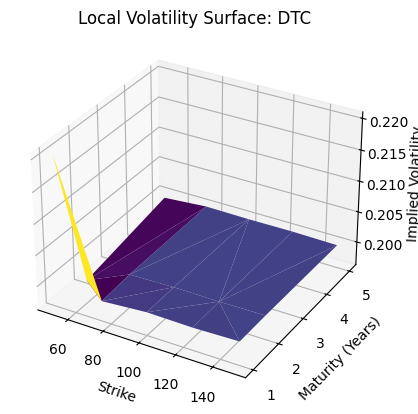

In [ ]:
plot_vol_surface(vol_surface, STOCKS[0])

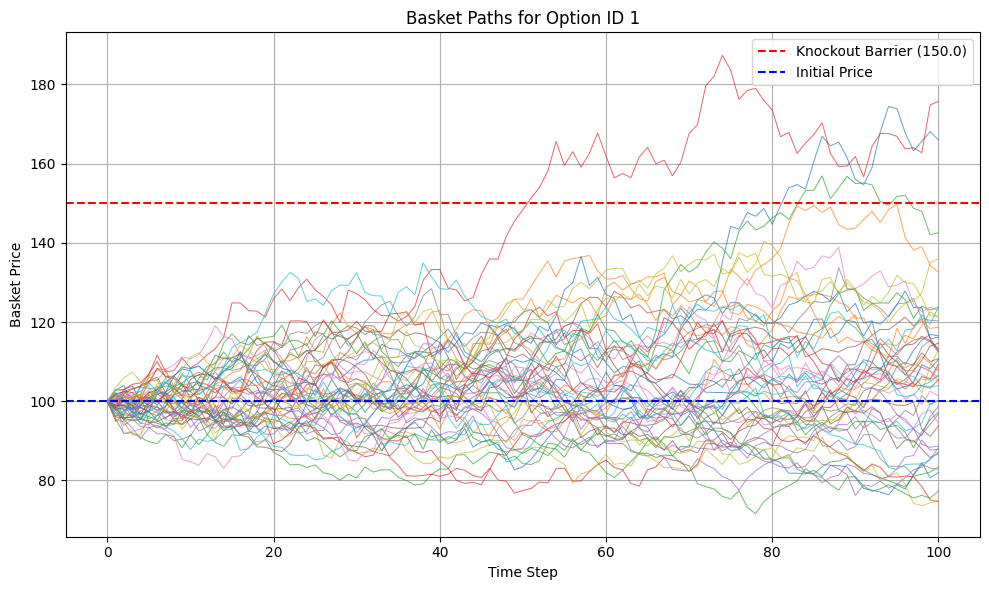

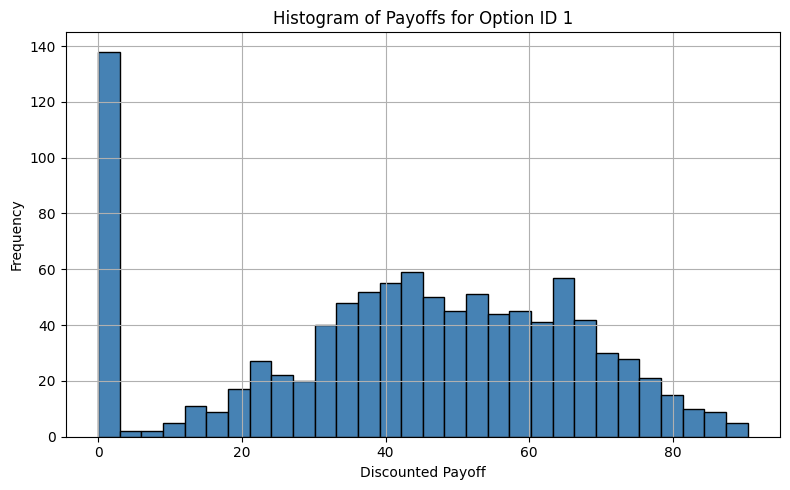

In [ ]:
plot_basket_paths_for_option(pricer, data_df.iloc[0])
plot_payoff_histogram(pricer, data_df.iloc[0])

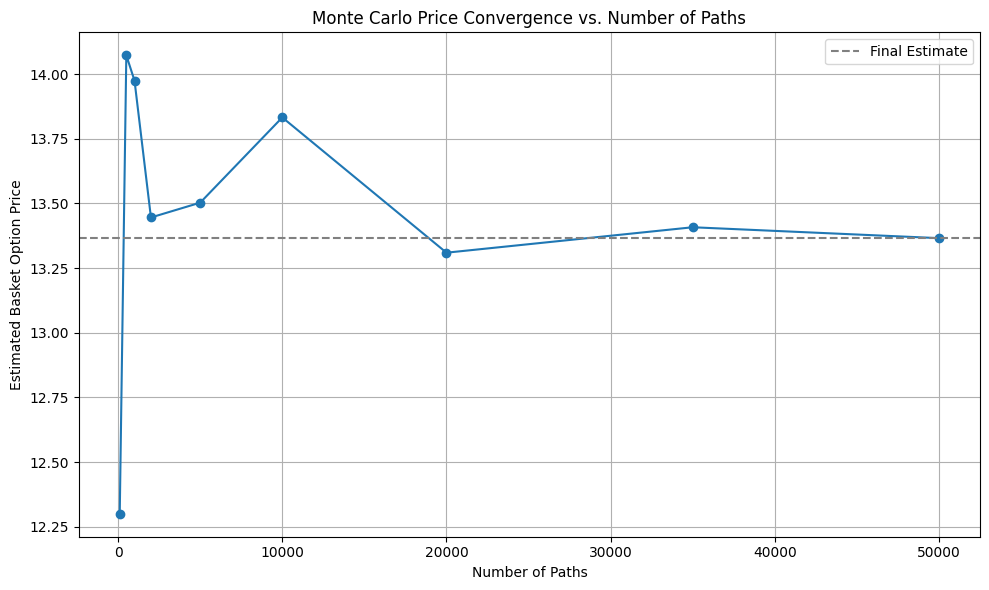

In [ ]:
option = {
    'Maturity': '2y',
    'Strike': 100,
    'KnockOut': 200,
    'Type': 'Call'
}

# Run convergence test
path_counts = [100, 500, 1000, 2000, 5000, 10000, 20000, 35000, 50000,]
prices = []

for n in path_counts:
    pricer = BasketOptionPricer(vol_surface, n_paths=n, n_steps=100)
    price = pricer.price_option(option)
    prices.append(price)

# Plot
plt.figure(figsize=(10,6))
plt.plot(path_counts, prices, marker='o')
plt.axhline(prices[-1], color='gray', linestyle='--', label='Final Estimate')
plt.title('Monte Carlo Price Convergence vs. Number of Paths')
plt.xlabel('Number of Paths')
plt.ylabel('Estimated Basket Option Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('mc_convergence_plot.png')
plt.show()

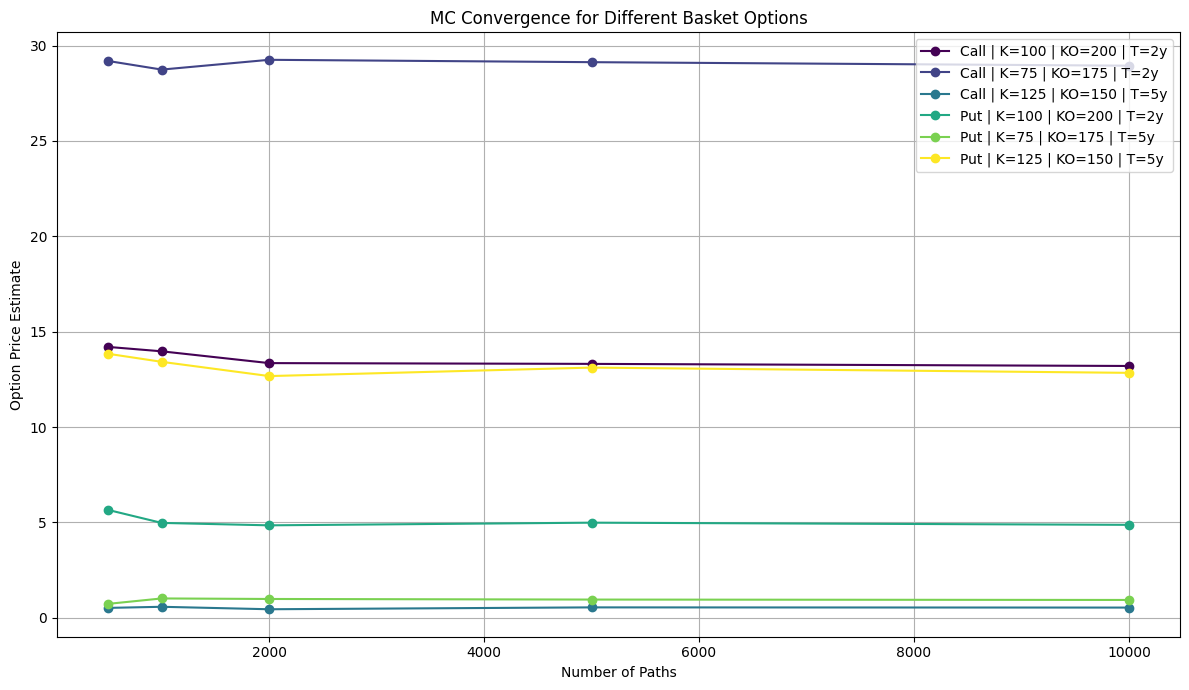

In [ ]:
# Multiple options convergence
options = [
    {'Maturity': '2y', 'Strike': 100, 'KnockOut': 200, 'Type': 'Call'},
    {'Maturity': '2y', 'Strike': 75,  'KnockOut': 175, 'Type': 'Call'},
    {'Maturity': '5y', 'Strike': 125, 'KnockOut': 150, 'Type': 'Call'},
    {'Maturity': '2y', 'Strike': 100, 'KnockOut': 200, 'Type': 'Put'},
    {'Maturity': '5y', 'Strike': 75,  'KnockOut': 175, 'Type': 'Put'},
    {'Maturity': '5y', 'Strike': 125, 'KnockOut': 150, 'Type': 'Put'},
]

path_counts = [500, 1000, 2000, 5000, 10000]
colors = plt.cm.viridis(np.linspace(0, 1, len(options)))

# Plotting
plt.figure(figsize=(12, 7))
for idx, opt in enumerate(options):
    prices = []
    for n in path_counts:
        pricer = BasketOptionPricer(vol_surface, n_paths=n, n_steps=100)
        price = pricer.price_option(opt)
        prices.append(price)

    label = f"{opt['Type']} | K={opt['Strike']} | KO={opt['KnockOut']} | T={opt['Maturity']}"
    plt.plot(path_counts, prices, marker='o', label=label, color=colors[idx])

plt.title("MC Convergence for Different Basket Options")
plt.xlabel("Number of Paths")
plt.ylabel("Option Price Estimate")
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("multi_option_convergence.png")
plt.show()

# AUTOMATED MARKET MAKING

**Problem Statement:** <br>
Built an adaptive quoting strategy that mimics a market-maker in a volatile, real-time environment. At every timestamp, we quote bit price and ask price based on the L2 order book, recent public trades, and the current inventory.

We aim to maximize total PnL while keeping inventory within ±20 units.

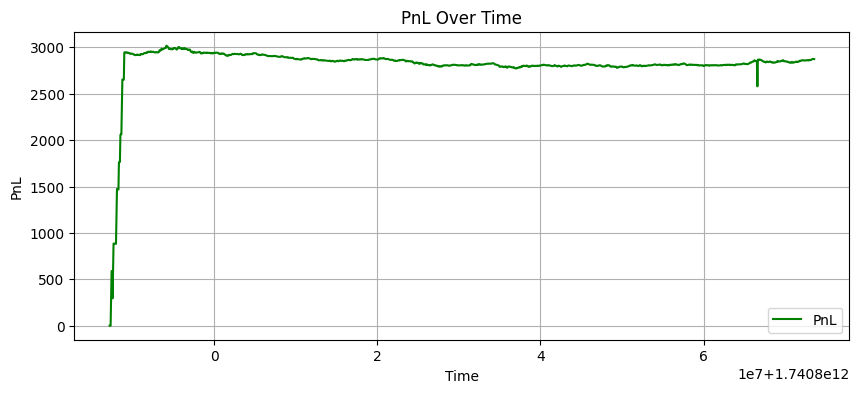

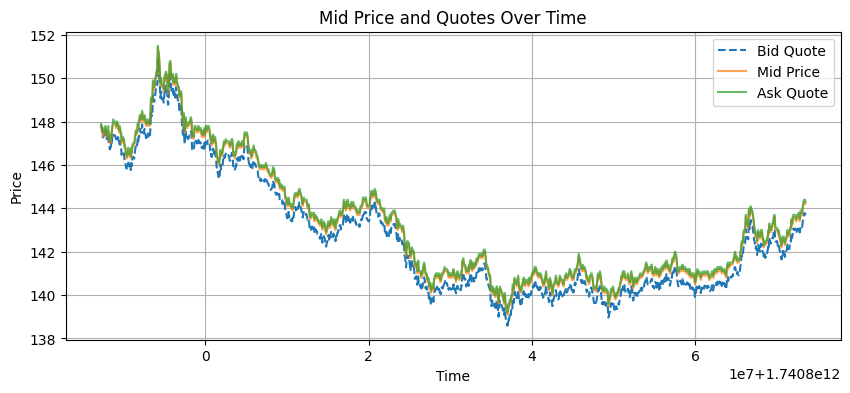

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AutomatedMarketMaking:
    def __init__(self, tick_size=0.1, lot_size=2):
        self.tick_size  = tick_size
        self.lot_size   = lot_size
        self.reset_simulator()

    def reset_simulator(self):
        self.inventory  = 0
        self.active_bid = None
        self.active_ask = None
        self.valid_from = None

        self.vol_ema     = None
        self.alpha_vol   = 0.2

    def update_quote(self, timestamp, bid_price, ask_price):
        # Post or update your quote at timestamp It takes effect at t+1
        self.active_bid = bid_price
        self.active_ask = ask_price
        self.valid_from = timestamp + 1

    def process_trades(self, timestamp, trades_at_t):
        # Process all public trades at timestamp Returns updated inventory
        if self.valid_from is None or timestamp < self.valid_from:
            return self.inventory

        filled = False

        MAX_INV = 20

        # sellside fill against your bid
        sells = trades_at_t[trades_at_t.side == 'sell']
        if self.active_bid is not None and not sells.empty:
            if self.active_bid >= sells.price.max() and self.inventory + self.lot_size <= MAX_INV:
                self.inventory += self.lot_size
                self.active_bid = None
                filled = True

        # buyside fill against your ask
        buys = trades_at_t[trades_at_t.side == 'buy']
        if self.active_ask is not None and not buys.empty:
            if self.active_ask <= buys.price.min() and self.inventory - self.lot_size >= -MAX_INV:
                self.inventory -= self.lot_size
                self.active_ask = None
                filled = True


        if filled:
            # deactivate until next update
            self.valid_from = float('inf')

        return self.inventory

    def calc_volatility(self, ob_recent, default_vol=0.01):

        mid = (ob_recent.bid_1_price) + (ob_recent.ask_1_price - ob_recent.bid_1_price) / 2

        if len(mid) > 1:
            log_returns = np.diff(np.log(mid))
            inst_vol = np.std(log_returns) * np.sqrt(len(log_returns))
        else:
            inst_vol = default_vol

        if self.vol_ema is None:
            self.vol_ema = inst_vol
        else:
            self.vol_ema = self.alpha_vol * inst_vol + (1 - self.alpha_vol) * self.vol_ema

        price_range = mid.max() - mid.min()
        range_vol = price_range / mid.mean() if mid.mean() > 0 else default_vol
        vol = max(self.vol_ema, range_vol, default_vol)
        return vol

    def strategy(self, ob_df, tr_df, inventory, t):

        ob_recent = ob_df[ob_df.timestamp <= t].tail(50)
        if ob_recent.empty:
            return None, None
        row = ob_recent.iloc[-1]
        best_bid = row.bid_1_price
        best_ask = row.ask_1_price
        mid_price = (best_bid + best_ask) / 2
        market_spread = best_ask - best_bid

        sigma = self.calc_volatility(ob_recent)
        dt = 1.0

        gamma = 0.1 + 0.005 * abs(inventory)
        k = 1.5

        r = mid_price - inventory * gamma * sigma**2 * dt

        half_spread = gamma * sigma**2 * dt + (2 / gamma) * np.log(1 + gamma / k)

        skew = 0.5 * (inventory / 20)

        bid = r - half_spread + skew * half_spread
        ask = r + half_spread + skew * half_spread

        max_spread = market_spread * 3
        if (ask - bid) > max_spread:
            mid = (ask + bid) / 2
            bid = mid - max_spread / 2
            ask = mid + max_spread / 2

        if abs(inventory) > 0.8 * 20:
            if inventory > 0:
                ask = min(ask, best_bid + 2 * self.tick_size)
            else:
                bid = max(bid, best_ask - 2 * self.tick_size)

        bid = np.floor(bid / self.tick_size) * self.tick_size
        ask = np.ceil(ask / self.tick_size) * self.tick_size
        if bid >= ask:
            ask = bid + self.tick_size

        bid_price = round(bid, 1)
        ask_price = round(ask, 1)

        return bid_price, ask_price


    def run(self, ob_df, tr_df):
        self.reset_simulator()
        quotes = []
        inv_history = []
        pnl_history = []
        mid_history = []
        spread_history = []
        time_axis = []

        cash = 0  # Track realized PnL
        price_last = None


        all_ts = sorted(ob_df.timestamp.unique())
        for t in all_ts:
            trades_t = tr_df[tr_df.timestamp == t]
            inv      = self.process_trades(t, trades_t)
            if not trades_t.empty:
                price_last = trades_t.iloc[-1].price
                if self.active_bid is None and self.active_ask is None:
                    # executed, so update cash
                    cash += -price_last * self.lot_size * np.sign(self.inventory)

            inv_history.append(self.inventory)
            pnl_history.append(cash + self.inventory * price_last if price_last else cash)

            row = ob_df[ob_df.timestamp == t].iloc[0]
            mid = (row.bid_1_price + row.ask_1_price) / 2
            spread = row.ask_1_price - row.bid_1_price

            mid_history.append(mid)
            spread_history.append(spread)
            time_axis.append(t)


            bid, ask = self.strategy(ob_df, tr_df, inv, t)

            self.update_quote(t, bid, ask)


            quotes.append({
                'timestamp': t,
                'bid_price': bid,
                'ask_price': ask
            })


        # Plot PnL over time
        plt.figure(figsize=(10, 4))
        plt.plot(time_axis, pnl_history, label='PnL', color='green')
        plt.title('PnL Over Time')
        plt.xlabel('Time')
        plt.ylabel('PnL')
        plt.grid()
        plt.legend()
        plt.savefig('pnl_plot.png')
        plt.show()



        # Plot Mid Price with Quotes
        plt.figure(figsize=(10, 4))
        plt.plot(time_axis, mid_history, label='Bid Quote', linestyle='--')
        plt.plot([q['timestamp'] for q in quotes], [q['bid_price'] for q in quotes], label='Mid Price', alpha=0.7)
        plt.plot([q['timestamp'] for q in quotes], [q['ask_price'] for q in quotes], label='Ask Quote', alpha=0.7)
        plt.title('Mid Price and Quotes Over Time')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.grid()
        plt.legend()
        plt.savefig('quotes_vs_mid.png')

        return pd.DataFrame(quotes)

if __name__ == "__main__":
    ob_obj = pd.read_csv('orderbook_train.csv')
    tr_obj = pd.read_csv('public_trades_train.csv')

    #pick top 3k timestamps
    ob_obj = ob_obj.head(3000);
    tr_obj = tr_obj.head(3000);

    amm = AutomatedMarketMaking(tick_size=0.1, lot_size=2)

    df_submission = amm.run(ob_obj, tr_obj)
    df_submission.to_csv('submission.csv', index=False)
    quotes_df = pd.read_csv('submission.csv').head(3000)


# OPTIMAL HEDGING STRATEGY

**Problem Statement:** <br>
Identify a set of hedging stocks from a universe of publicly traded equity stocks and determine the quantity of each stock needed to minimize risk, while also considering the cost of implementing the hedge.

These equity stocks have known risk profiles, represented by their historical daily returns, and a known hedging cost per share.

The evaluation criteria will be based on the 95%ile VaR of the hedged portfolio and the total capital cost of implementing the hedge. The goal is to minimize both VaR and cost.

In [ ]:
from sklearn.linear_model import Lasso
import xgboost as xgb
import numpy as np
import pandas as pd
import sys

from sklearn.linear_model import QuantileRegressor

# Load data
returns = pd.read_csv("stocks_returns.csv") / 100.0
metadata = pd.read_csv("stocks_metadata.csv")

R = returns.iloc[:, 1:].to_numpy(dtype=np.float64)  # (T, N)
T, N = R.shape

costs = metadata["Capital_Cost"].to_numpy(dtype=np.float64)  # (N,)
ids = metadata["Stock_Id"].to_numpy()

# Read P&L
tokens = input().strip().split()
pnl = np.array(list(map(float, tokens[1:])), dtype=np.float64)

# Metadata-aware scaling
rating_map = {'AAA': 8, 'AA': 7, 'A': 6, 'BBB': 5, 'BB': 4, 'B': 3, 'CCC': 2, 'CC': 1, 'C': 0}
metadata["rating_val"] = metadata["Rating"].map(rating_map).fillna(0).astype(int)
metadata["market_cap_val"] = metadata["Market_Cap"].map({"small": .5, "medium": 1.0, "large": 1.5}).fillna(1.0)

ratings = metadata["rating_val"].to_numpy(dtype=np.float64)
mcaps = metadata["market_cap_val"].to_numpy(dtype=np.float64)

rating_factor = (ratings - ratings.mean()) / (ratings.std() + 1e-8)
mcap_factor = (mcaps - mcaps.mean()) / (mcaps.std() + 1e-8)
scale_vector = 1.0 + 0.05 * rating_factor + 0.05 * mcap_factor

R_scaled = R * scale_vector[None, :]
X = R_scaled
y = -pnl


Portfolio_15 -143.947242 -54.696053 -194.050843 -114.379762 -250.914222 94.525127 -38.578749 87.924437 71.989914 11.229715 294.581902 -280.166856 164.614297 -65.917684 5.897927 150.181106 263.998383 174.068129 88.060921 -223.012161 266.605458 80.822122 158.287567 -9.023034 22.444253 -33.883753 -261.471284 -91.303422 -83.428574 33.292501 -73.951395 -176.659194 -135.428729 62.436845 -136.566712 -173.370305 -283.001479 107.665112 -53.090612 95.636076 139.235617 -19.10865 85.199601 -209.1056 -310.955306 -2.165499 35.976801 7.50174 73.062716 -203.179266 469.00358 127.236235 3.716109 252.211904 174.502566 6.919277 339.092547 4.422581 5.965394 -173.426425 -30.290419 -185.455906 65.674427 116.629944 -109.198075 78.179203 -115.110464 -177.391446 -119.218134 166.293029 -76.239738 171.411876 -141.504239 139.137473 -25.01957 -20.231675 55.088898 2.876409 -44.997561 -9.161336 -72.560697 283.933358 -34.321216 -135.798794 110.626876 -192.54237 119.526443 -1.670631 27.555595 -40.781872 -235.559946 107

### Top 20 stocks using xgboost

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    verbosity=0
)
model_xgb.fit(X, y)

importances = model_xgb.feature_importances_
feature_ranks = np.argsort(-importances)  # descending sort

print("Top 20 stocks by XGBoost importance:")
for i, idx in enumerate(feature_ranks[:20], 1):
    print(f"{i}: {ids[idx]}: importance = {importances[idx]:.4f}")


Top 20 stocks by XGBoost importance:
1: stock_279: importance = 0.0487
2: stock_212: importance = 0.0431
3: stock_134: importance = 0.0376
4: stock_276: importance = 0.0347
5: stock_122: importance = 0.0313
6: stock_213: importance = 0.0304
7: stock_215: importance = 0.0302
8: stock_266: importance = 0.0278
9: stock_50: importance = 0.0277
10: stock_261: importance = 0.0271
11: stock_63: importance = 0.0213
12: stock_275: importance = 0.0170
13: stock_223: importance = 0.0158
14: stock_141: importance = 0.0143
15: stock_6: importance = 0.0138
16: stock_159: importance = 0.0134
17: stock_109: importance = 0.0133
18: stock_181: importance = 0.0125
19: stock_199: importance = 0.0118
20: stock_66: importance = 0.0115


In [ ]:
from sklearn.linear_model import QuantileRegressor
import numpy as np
import pandas as pd
import sys


alphas = np.logspace(-6, -2, 11)
best_score = np.inf
best_coef = None
best_alpha = None

for alpha in alphas:
    model = QuantileRegressor(quantile=0.05, alpha=alpha, fit_intercept=False, solver="highs")
    model.fit(X, y)
    w = model.coef_
    pnl_hedged = pnl + X @ w
    var95 = -np.percentile(pnl_hedged, 5.0)
    cost = np.dot(costs, np.abs(w))
    score = var95 * cost
    if score < best_score:
        best_score = score
        best_coef = w
        best_alpha = alpha

total_cost = np.dot(costs, np.abs(best_coef))

if total_cost > 10_000_000:
    corr_vec = np.corrcoef(R.T, pnl)[-1, :-1]
    corr_vec = np.nan_to_num(corr_vec, nan=0.0)
    impact_score = np.abs(best_coef) * np.abs(corr_vec)
    topk_idx = np.argsort(-impact_score)[:5]

    X_top = R[:, topk_idx]
    model = QuantileRegressor(quantile=0.05, alpha=best_alpha, fit_intercept=False, solver="highs")
    model.fit(X_top, y)
    w_top = model.coef_

    w = np.zeros(N)
    w[topk_idx] = w_top
    best_coef = w

w_int = np.round(best_coef).astype(np.int64)
mask = w_int != 0

if not mask.any():
    best_score = np.inf
    best_stock = -1
    best_qty = 0

    BUDGET = 10_000_000.0

    for i in range(R.shape[1]):
        x = R[:, i]
        y = -pnl
        num = np.dot(x, y)
        denom = np.dot(x, x) + 1e-6
        w_fallback = num/denom

        max_qty = BUDGET // costs[i]
        candidates = []

        # regression-based clipped qty
        qty1 = int(np.clip(np.round(w_fallback), -max_qty, max_qty))
        if qty1 != 0:
            candidates.append(qty1)

        # cautious (50% of budget)
        qty2 = int(np.sign(w_fallback) * 0.5 * max_qty)
        if qty2 != 0:
            candidates.append(qty2)

        # full budget
        qty3 = int(np.sign(w_fallback) * max_qty)
        if qty3 != 0:
            candidates.append(qty3)


        for qty in candidates:
            hedge_pnl = pnl + x * qty
            var = -np.percentile(hedge_pnl, 5.0)
            cost = abs(qty) * costs[i]
            score = var
            #if i> 80 and i<90:
                #print(f"[Fallback Trial] Stock: {ids[i]}, Qty: {qty}, VaR95: {var:.2f}, Cost: {cost:.2f}, Score: {score:.6f}")
            if score < best_score:  # minimize VaR / cost
                best_score = score
                best_stock = i
                best_qty = qty
                best_hedge_pnl = hedge_pnl

    w_int = np.zeros_like(costs, dtype=np.int64)
    if best_stock != -1:
        w_int[best_stock] = best_qty
        mask = w_int != 0

        #print(f"Stock: {ids[best_stock]}, Qty: {best_qty}, VaR95: {best_score:.2f}, Cost: {abs(best_qty) * costs[best_stock]:.2f}")

for sid, qty in zip(ids[mask], w_int[mask]):
    print(f"{sid} {qty}")
import matplotlib.pyplot as plt


stock_1 -732
stock_5 -119
stock_12 -104
stock_15 -655
stock_59 -832
stock_78 -256
stock_98 -370
stock_120 -617
stock_132 -8
stock_159 -826
stock_160 -495
stock_182 -64
stock_184 -197
stock_195 -375
stock_211 -928
stock_213 -784
stock_225 -928
stock_247 -491
stock_282 -245
stock_290 -262


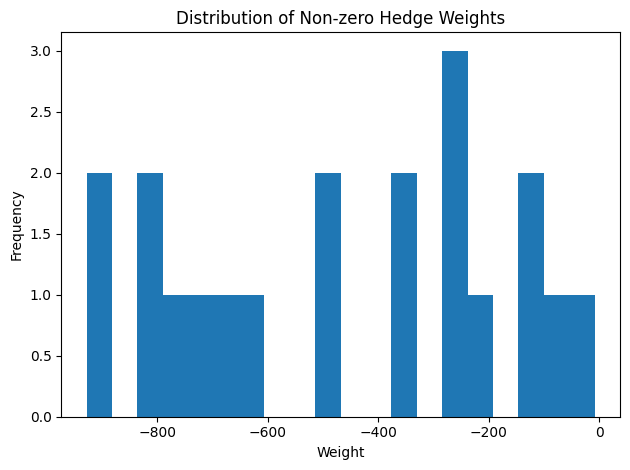

In [ ]:
plt.hist(w_int[w_int != 0], bins=20)
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.title("Distribution of Non-zero Hedge Weights")


plt.tight_layout()
plt.show()

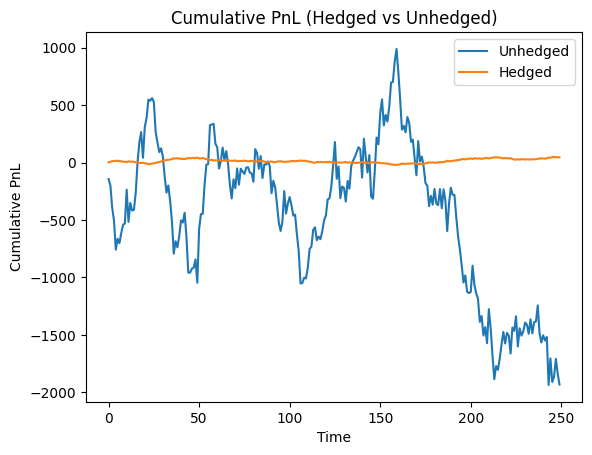

In [ ]:
plt.plot(np.cumsum(pnl), label="Unhedged")
plt.plot(np.cumsum(pnl + R @ w_int), label="Hedged")
plt.legend()
plt.title("Cumulative PnL (Hedged vs Unhedged)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.savefig("pnl_comparison.png")
plt.show()

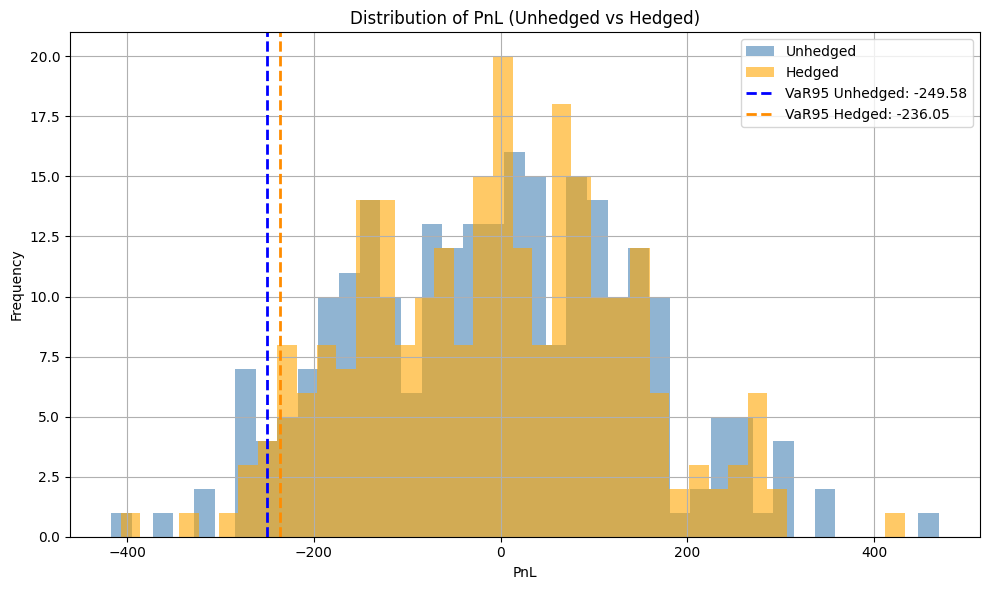

In [ ]:
var_unhedged = np.percentile(pnl, 5)
var_hedged = np.percentile(pnl_hedged, 5)

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(pnl, bins=40, alpha=0.6, label="Unhedged", color="steelblue")
plt.hist(pnl_hedged, bins=40, alpha=0.6, label="Hedged", color="orange")

# Plot VaR lines
plt.axvline(var_unhedged, color="blue", linestyle="--", linewidth=2, label=f"VaR95 Unhedged: {var_unhedged:.2f}")
plt.axvline(var_hedged, color="darkorange", linestyle="--", linewidth=2, label=f"VaR95 Hedged: {var_hedged:.2f}")

# Labels and legend
plt.title("Distribution of PnL (Unhedged vs Hedged)")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig("portfolio.png")
plt.tight_layout()
plt.show()